## 1. Load libraries - only need to do this once. 

In [1]:
# importing, data handling
import numpy as np
import pandas as pd
import ipyfilechooser
import os
import imageio
import imageio.v3 as iio
import tifffile
from PIL import Image
from skimage.color import rgb2gray

# plotting
import matplotlib  as mpl
import cv2
import matplotlib.pyplot as plt

# thresholding
from skimage import io, color, filters, morphology, measure
from skimage.draw import rectangle_perimeter

# tracking
import trackpy as tp

from IPython.display import Video, Markdown, display

import ODLabTracker
from ODLabTracker import tracking

## 2. Setup - click run on the cell below and select an image file

In [74]:
min_area = 50 #min area of worm in pixels
max_area = 2000 #max area of worm in pixels
gap_range = 8 # max number of frame gap to link worms (i.e. can a worm disappear for more frames?)
thresh = 140 # if not 'None', then manual threshold - set to a number (see below) to use if too few worms detected or too many short tracks
search_range = 60 # max pixel distance to link tracks across frames
min_length = 10 # minimum length of track in frames to keep
frame_rate = 10 # FPS - necessary for speed analysis and video writing
illumination = 1 # illumination source, 0 = white worms on dark (e.g. IR), 1 = dark worms on light. default 0


interactive = True;
if(interactive == True):
    workingDir = os.getcwd()
    #baseDir = os.path.dirname(workingDir)

    # need to install ipyfilechooser - use pip
    from ipyfilechooser import FileChooser

    # Create and display a FileChooser widget
    fc = FileChooser(workingDir)
    print("select the first .tiff file you want to analyze")
    display(fc)

else:
    fc.selected_filename = filepath
    fc.selected_path = os.path.splitext(filepath)[0]
    workingDir = os.getdwc()

display(Markdown('<strong>{}</strong>'.format("Parameter settings below")))
print(f'minimum area of worm in pixels: {min_area}')
print(f'maximum area of worm in pixels: {max_area}')
print(f'gap range of worms in frames: {gap_range}')
if thresh:
    print(f'automatically calculating threshold')
else:
    print(f'manual threshold: {thresh}')
print(f'maximum pixel distance to link worms: {search_range}')
print(f'minimum length of worm track to keep in frames: {min_length}')
print(f'frame rate to use for speed analysis: {frame_rate}')
if illumination == 0:
    print(f'analyzing light worms on dark background')
else:
    print(f'analyzing dark worms on light background')

display(Markdown('<strong>{}</strong>'.format("Once you have selected the video, run the code in the next chunk (not this one again)")))

# default values small plate on IR light:
# min_area = 200 #min area of worm in pixels
# max_area = 2000 #max area of worm in pixels
# gap_range = 8 # max number of frame gap to link worms
# thresh = None # manual threshold - use if too few worms detected or too many short tracks
# search_range = 60 # max pixel distance to link tracks across frames
# min_length = 25 # minimum length of track in frames to keep
# frame_rate = 10 # FPS - only necessary for speed analysis
# illumination = 0 # illumination source, 0 = white worms on dark (e.g. IR), 1 = dark worms on light

select the first .tiff file you want to analyze


FileChooser(path='/Users/mikeodonnell/git/ODLabTracker', filename='', title='', show_hidden=False, select_desc…

<strong>Parameter settings below</strong>

minimum area of worm in pixels: 50
maximum area of worm in pixels: 2000
gap range of worms in frames: 8
automatically calculating threshold
maximum pixel distance to link worms: 60
minimum length of worm track to keep in frames: 10
frame rate to use for speed analysis: 10
analyzing dark worms on light background


<strong>Once you have selected the video, run the code in the next chunk (not this one again)</strong>

## 3. Optimize input parameters - you can skip to the full analysis if you're good with your settings

In [78]:
filename = fc.selected_filename

# test for different modes of video import converting to grayscale, add this to tracking.py when optimized

import time

start_time = time.time()
im = iio.imread(fc.selected)
end_time = time.time()
print(f"Reading in {im.shape[0]} frames of video took {end_time - start_time} seconds")
print(im.shape)

if im.shape[-1] == 3:
    display(Markdown('<strong>{}</strong>'.format("Video is RGB, need to convert to grayscale 8-bit - consider \n changing video output to this type ahead of time")))
    
frames = []

start_time = time.time()
for i, frame in enumerate(im):
    if i >= 50:
        break
    # Convert to grayscale only if RGB
    if frame.ndim == 3 and frame.shape[-1] == 3:
        if i == 1:
            print("converting to grayscale images")
        frame = rgb2gray(frame)
        frame = (frame * 255).astype(np.uint8)
    elif frame.ndim == 2:
        if i == 1: 
            print("already grayscale, converting to 8-bit")
        frame = frame.astype(np.uint8)
    # Append the processed frame to the list
    frames.append(frame)
end_time = time.time()
print(f"Converting {len(frames)} frames to 8-bit grayscale took {end_time - start_time} seconds")

print(f'Image appears to be resolution: {len(frames[0][0])} x {len(frames[0])} in pixels')

result_path = os.path.join(f"{os.path.splitext(fc.selected)[0]}_results")
print(f"results will be saved to {result_path}")
workingDir = os.getcwd()

Reading in 600 frames of video took 1.0517501831054688 seconds
(600, 1024, 1280, 3)


<strong>Video is RGB, need to convert to grayscale 8-bit - consider 
 changing video output to this type ahead of time</strong>

converting to grayscale images


/Users/mikeodonnell/.local/share/virtualenvs/ODLabTracker-UXIUAQZA/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/mikeodonnell/.local/share/virtualenvs/ODLabTracker-UXIUAQZA/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/mikeodonnell/.local/share/virtualenvs/ODLabTracker-UXIUAQZA/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


Converting 50 frames to 8-bit grayscale took 0.3454270362854004 seconds
Image appears to be resolution: 1280 x 1024 in pixels
results will be saved to /Users/mikeodonnell/Desktop/iaa_chemotaxis_labels-13963_results


Rendering  50  frames for threshold visualization


<strong>There should be white worms on black background, 
in the video there should be a box around all worms.
If not, you may need to adjust the threshold value manually
</strong>

Reading in 600 frames of video took 0.9435477256774902 seconds
Video is RGB, need to convert to grayscale 8-bit - consider 
 changing video output to this type ahead of time
Converting 50 frames to 8-bit grayscale took 0.3358621597290039 seconds
results will be saved to /Users/mikeodonnell/Desktop/iaa_chemotaxis_labels-13963_results
Manual threshold value is 140
Mean area of objects in pixels is 248.2058823529412


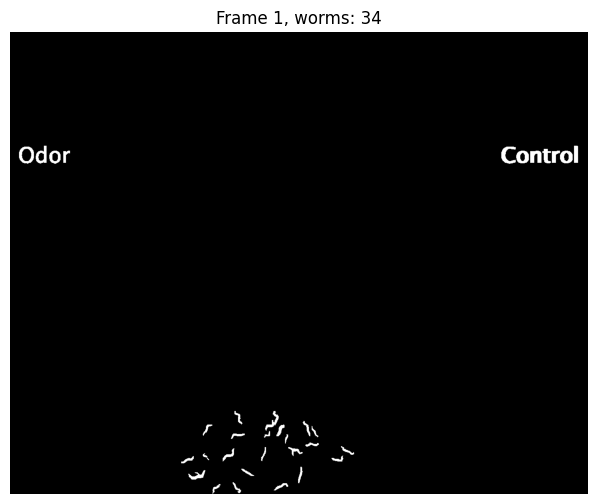

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...', height='320', wid…

In [79]:
print('Rendering ', len(frames), ' frames for threshold visualization')

display(Markdown('<strong>{}</strong>'.format("There should be white worms on black background, \nin the video there should be a box around all worms.\nIf not, you may need to adjust the threshold value manually\n")))

tracking.process_video(min_area, 
                       max_area, 
                       thresh=thresh, 
                       input_path=fc.selected, 
                       output_path=result_path, 
                       save_as="mp4", 
                       max_frames=50,
                       fps=frame_rate,
                      illumination=illumination)
from ipywidgets import Video
Video.from_file(os.path.join(result_path,"worms_annotated.mp4"), width=480, height=320)

## 4. Run for the whole video after converting to 8-bit grayscale

Frame 599: 23 trajectories present.
Mean track length is  58.0  frames
Minimum track length is  1
Maximum track length is  600


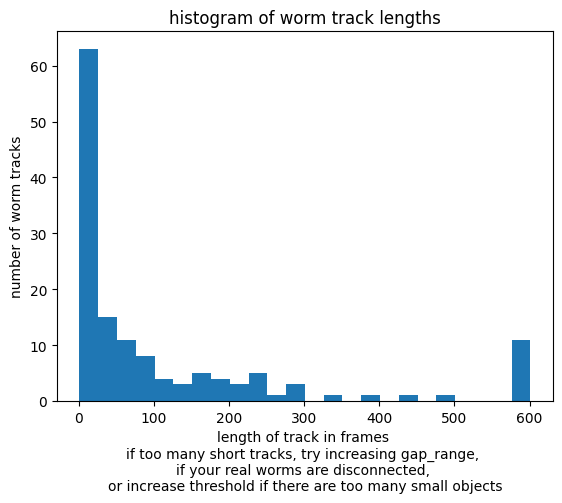

removing tracks shorter than 10 frames
plotting linked and filtered worm tracks


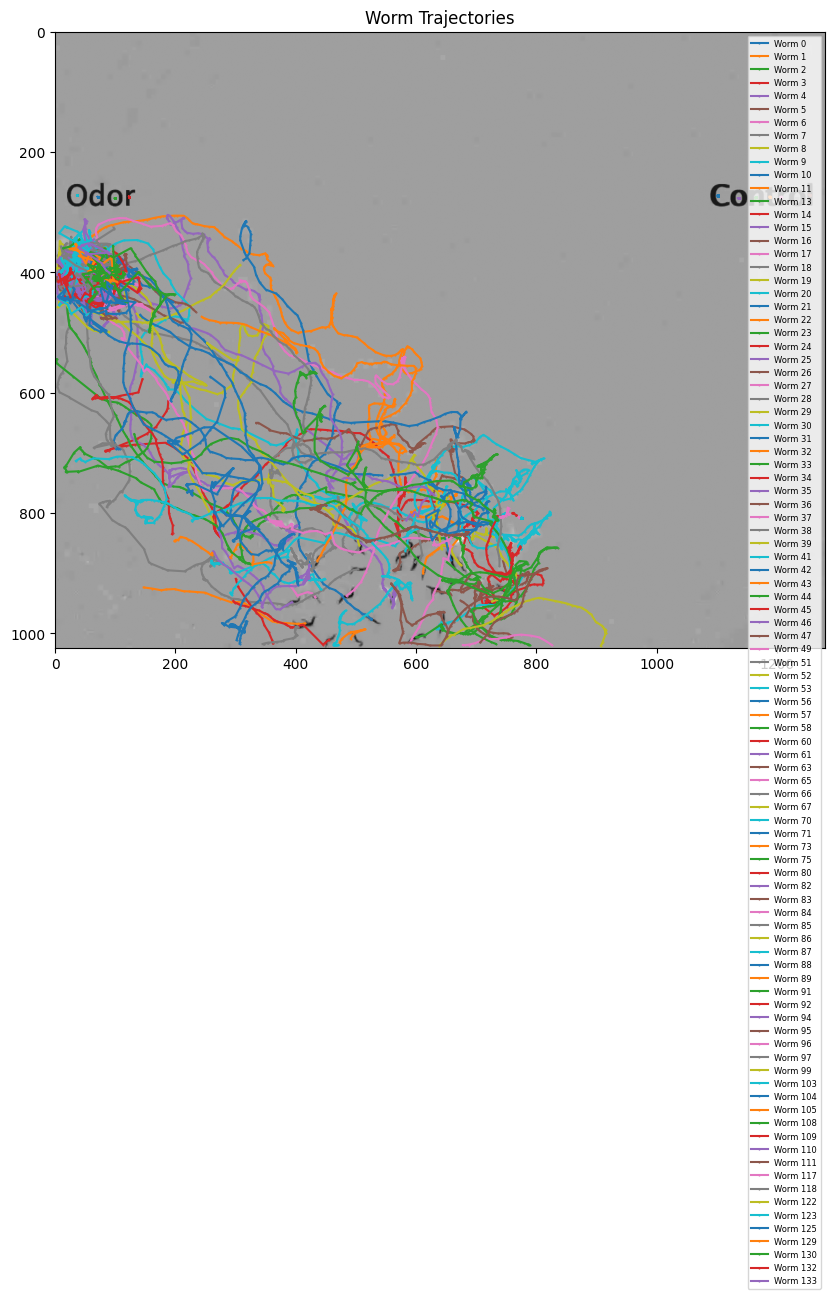

saving tracked centroids to /Users/mikeodonnell/Desktop/iaa_chemotaxis_labels-13963_results/tracks.csv


In [80]:
# if that looks good, run for the whole video after converting to 8-bit grayscale
frames = []
start_time = time.time()
for i, frame in enumerate(im):
    # Convert to grayscale only if RGB
    if frame.ndim == 3 and frame.shape[-1] == 3: 
        #print("converting to grayscale images")
        frame = rgb2gray(frame)
        frame = (frame * 255).astype(np.uint8)
    elif frame.ndim == 2:  # already grayscale
        #print("converting to 8-bit")
        frame = frame.astype(np.uint8)
        # Append the processed frame to the list
    frames.append(frame)
end_time = time.time()
print(f"Converting {len(frames)} frames to 8-bit grayscale took {end_time - start_time} seconds")

# now simple track for the whole video and link tracks together
first_frame = frames[0]

# # Compute global threshold
# _, _, global_thresh = tracking.preprocess_frame(first_frame, 
#                                                 min_area, 
#                                                 max_area, 
#                                                 thresh, 
#                                                 illumination=illumination)

# Collect detections
if thresh:
    detections = tracking.collect_detections(frames, 
                                             thresh, 
                                             min_area, 
                                             max_area,
                                             illumination=illumination)
else:
    detections = tracking.collect_detections(frames, 
                                             global_thresh, 
                                             min_area, 
                                             max_area,
                                            illumination-illumination)

# Link tracks
tracks = tracking.link_tracks(detections, search_range=search_range, memory=gap_range)

# Now tracks['particle'] is a persistent worm ID

# visualize the track length of each "worm"
# if there are background particles, this will lead to a ton of short tracks

counts = tracks.groupby("particle")["frame"].count()
print('Mean track length is ',np.ceil(np.mean(counts)/2), ' frames')
print('Minimum track length is ',int(min(counts)))
print('Maximum track length is ',int(max(counts)))
#plt.figure(figsize=(10,8))
binwidth = 25
plt.hist(counts, bins=range(int(min(counts)), int(max(counts)) + binwidth, binwidth))
plt.xlabel("length of track in frames")
plt.title("histogram of worm track lengths")
plt.xlabel("length of track in frames \nif too many short tracks, try increasing gap_range, \nif your real worms are disconnected, \nor increase threshold if there are too many small objects")
plt.ylabel("number of worm tracks")
plt.show()

# Remove short tracks
print(f'removing tracks shorter than {min_length} frames')
tracks = tracking.filter_short_tracks(tracks, min_length=min_length)

# Plot over first frame
print('plotting linked and filtered worm tracks')
tracking.plot_trajectories(stack=first_frame, tracks=tracks, output_path=result_path)

# Save the track centroids to a csv file
print(f'saving tracked centroids to {os.path.join(result_path,"tracks.csv")}')
tracks.to_csv(os.path.join(result_path,"tracks.csv"), index=False)


## 5. Below is slow method for posture analysis 

In [60]:
gray = first_frame
print(global_thresh)
search_diameter = round(np.sqrt(max_area)/2) # search diameter for object detection
if search_diameter % 2 == 0:
    search_diameter = search_diameter + 1
# unclear to me why threshold
start_time = time.time()
f = tp.locate(gray, diameter=search_diameter, threshold = (global_thresh/20))
end_time = time.time()
total_time = end_time - start_time
print(f"That one frame took {total_time} seconds")


140
That one frame took 0.30466222763061523 seconds


In [61]:
f.head()

,y,x,mass,size,ecc,signal,raw_mass,ep
0,278.433847,1164.117647,7164.780807,5.275614,0.469646,87.517681,37515.0,-0.004422
1,276.620068,99.271340,7446.210212,4.873681,0.189734,66.582079,43527.0,-0.005740
2,276.284900,68.920288,7582.120022,4.758798,0.208443,71.730178,42026.0,-0.005343
3,276.642966,1134.714917,7684.395587,4.562126,0.239202,78.594309,38071.0,-0.004518
4,276.628361,1231.723991,7633.601011,4.564571,0.247871,79.967136,38107.0,-0.004524


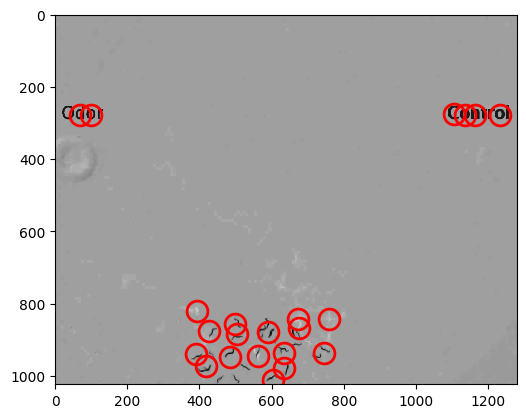

In [62]:
tp.annotate(f, first_frame);

[Text(0.5, 0, 'mass'), Text(0, 0.5, 'count')]

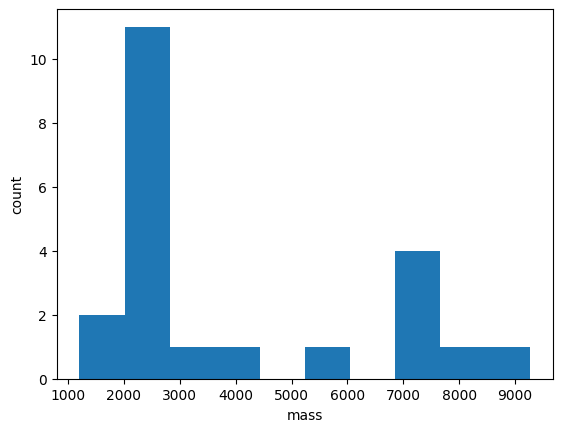

In [63]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=10)
ax.set(xlabel='mass', ylabel='count')

In [64]:
f = tp.batch(frames[:1000], diameter=search_diameter, threshold = (global_thresh/20));

Frame 599: 32 features


In [67]:
t = tp.link(f, 50, memory=10)

Frame 599: 32 trajectories present.


In [68]:
t.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,278.433847,1164.117647,7164.780807,5.275614,0.469646,87.517681,37515.0,-0.004422,0,0
21,1012.849431,604.776594,2384.256192,6.221211,0.435079,21.965222,56140.0,-0.015324,0,1
20,978.717775,635.300546,2641.317929,6.247692,0.449357,20.935602,57045.0,-0.017410,0,2
19,973.880532,419.201970,2683.189133,5.563041,0.095395,32.261420,55312.0,-0.013811,0,3
18,946.868015,485.130392,2800.565788,5.794235,0.402029,27.456527,55551.0,-0.014216,0,4


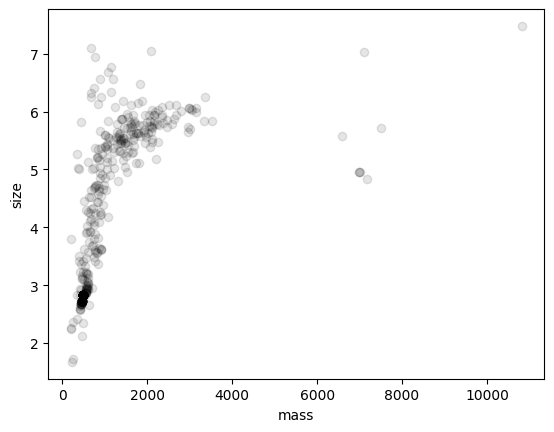

In [69]:
plt.figure()
tp.mass_size(t.groupby('particle').mean());

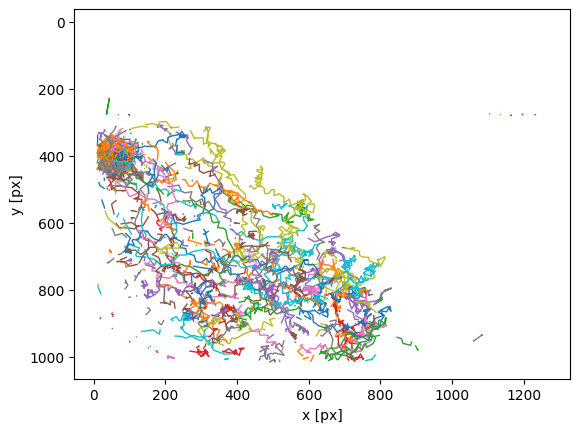

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [70]:
tp.plot_traj(t)